In [1]:
import gym
import os
import time
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from gym import wrappers
from PIL import Image
from itertools import count
from collections import namedtuple

from DQN.dqn import DQN_Conv
from DQN.buffer import ReplayBuffer
from DQN.utils import get_screen, mkdir

In [2]:
env_name = 'CartPole-v1'
lr_base = 0.001
lr_decay = 0.0001
epsilon_base = 0.5 
epsilon_decay = 0.002

random_seed = 42
gamma = 0.99                # discount for future rewards
batch_size = 32        # num of transitions sampled from replay buffer
polyak = 0.999               # target policy update parameter (1-tau)
max_episodes = 100000         # max num of episodes
max_timesteps = 3000        # max timesteps in one episode
max_buffer_length = 5000000
log_interval = 10           # print avg reward after interval

In [3]:
conv_config = [
    {'dim': [3,16], 'kernel': 5, 'stride': 2, 'batch_norm': True, 'activation': 'relu'},
    {'dim': [16,32], 'kernel': 5, 'stride': 2, 'batch_norm': True, 'activation': 'relu'},
    {'dim': [32,32], 'kernel': 5, 'stride': 2, 'batch_norm': True, 'activation': 'relu'},
]

fc_config = [
        {'dim': [448, None], 'dropout': False, 'activation': False}
    ] 
config = [conv_config, fc_config]

In [4]:
class DQN_Conv_Trainer():
    
    def __init__(self, env_name, fc_config, random_seed=42, lr_base=0.001, lr_decay=0.00005, 
                 epsilon_base=0.3, epsilon_decay=0.0001, gamma=0.99, batch_size=1024, 
                 max_episodes=100000, max_timesteps=3000, max_buffer_length=5000000, 
                 log_interval=5, threshold=None, lr_minimum=1e-10, epsilon_minimum=1e-10,
                 record_videos=True, record_interval=100):        
        
        self.algorithm_name = 'dqn'
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.record_videos = record_videos
        self.record_interval = record_interval        
        if self.record_videos == True:
            videos_dir = mkdir('.', 'videos')
            monitor_dir = mkdir(videos_dir, self.algorithm_name)
            should_record = lambda i: self.should_record
            self.env = wrappers.Monitor(self.env, monitor_dir, video_callable=should_record, force=True)            
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n    
        self.should_record = False
        if not threshold == None:
            self.threshold = threshold
        else:    
            self.threshold = self.env.spec.reward_threshold
              
        self.config = config
        #self.fc_config[0]['dim'][0] = self.state_dim
        self.config[1][-1]['dim'][1] = self.action_dim    
        self.conv_config = self.config[0]
        self.fc_config = self.config[1]
        
        self.random_seed = random_seed
        self.lr_base = lr_base
        self.lr_decay = lr_decay
        self.lr_minimum = lr_minimum  
        self.epsilon_base = epsilon_base
        self.epsilon_decay = epsilon_decay
        self.epsilon_minimum = epsilon_minimum
        self.gamma = gamma
        self.batch_size = batch_size              
        self.max_episodes = max_episodes
        self.max_timesteps = max_timesteps
        self.max_buffer_length = max_buffer_length
        self.log_interval = log_interval
        
        prdir = mkdir('.', 'preTrained')
        self.directory = mkdir(prdir, self.algorithm_name)
        self.filename = "{}_{}_{}".format(self.algorithm_name, self.env_name, self.random_seed)
        
        self.policy = DQN_Conv(self.env, self.conv_config, self.fc_config)   
        self.replay_buffer = ReplayBuffer(size=self.max_buffer_length)
        
        self.reward_history = []
        self.make_plots = False       
        
        if self.random_seed:
            print("Random Seed: {}".format(self.random_seed))
            self.env.seed(self.random_seed)
            torch.manual_seed(self.random_seed)
            np.random.seed(self.random_seed)
            
    def train(self):
        
        start_time = time.time()   
        self.env.reset()
        
        plt.figure()
        plt.imshow(get_screen(self.env).cpu().squeeze(0).permute(1, 2, 0).numpy(),interpolation='none')
        plt.title('Example extracted screen')
        plt.show()
                
        print("Action_space={}".format(self.env.action_space))
        print("Obs_space={}".format(self.env.observation_space))
        print("Threshold={} \n".format(self.threshold))        

        # loading models
        self.policy.load(self.directory, self.filename)
                
        # logging variables:        
        log_f = open("train_{}.txt".format(self.algorithm_name), "w+")
        
        print("\nTraining started ... ")
                
        # training procedure:        
        for episode in range(self.max_episodes):
            
            # Only record video during evaluation, every n steps
            if episode % self.record_interval == 0:
                self.should_record = True
            
            self.env.reset()
            ep_reward = 0.0                    
            last_screen = get_screen(self.env)
            current_screen = get_screen(self.env)
            state = current_screen - last_screen
                       
            # calculate params
            epsilon = max(self.epsilon_base / (1.0 + episode * self.epsilon_decay), self.epsilon_minimum)
            learning_rate = max(self.lr_base / (1.0 + episode * self.lr_decay), self.lr_minimum)      
            self.policy.set_optimizers(lr=learning_rate)
           
            for t in range(self.max_timesteps):
                
                action = self.policy.select_action(state, epsilon)                
                _, reward, done, _ = self.env.step(action)          
                
                last_screen = current_screen
                current_screen = get_screen(self.env)
                if not done:
                    next_state = current_screen - last_screen
                
                state = state.squeeze(0)
                next_state = next_state.squeeze(0)
                #print ("STATE: {} NEXT: {}".format(state.shape, next_state.shape))
                self.replay_buffer.add(state, action, reward, next_state, float(done))
                
                # Updating policy
                self.policy.update(self.replay_buffer, t, self.batch_size, self.gamma)
                                
                state = next_state               
                ep_reward += reward            
                
                if done:
                    break
           
            self.reward_history.append(ep_reward)
            avg_reward = np.mean(self.reward_history[-100:]) 
                       
            # logging updates:        
            log_f.write('{},{}\n'.format(episode, ep_reward))
            log_f.flush()
           
            if len(self.policy.Q_loss_list) > 0:               
                avg_Q_loss = np.mean(self.policy.Q_loss_list[-100:])     
            
            # Truncate training history if we don't plan to plot it later
            if not self.make_plots:
                self.policy.truncate_loss_lists() 
                if len(self.reward_history) > 100:
                    self.reward_history.pop(0)    
         
            # Print avg reward every log interval:
            if episode % self.log_interval == 0:            
                self.policy.save(self.directory, self.filename)
                print("Ep:{:5d}  Rew:{:8.2f}  Avg Rew:{:8.2f}  LR:{:8.8f}  Bf:{:2.0f}  EPS:{:0.4f}  Loss: {:5.3f}".format(
                    episode, ep_reward, avg_reward, learning_rate, self.replay_buffer.get_fill(), 
                    epsilon, avg_Q_loss))
                        
            self.should_record = False
            
            # if avg reward > threshold then save and stop traning:
            if avg_reward >= self.threshold and episode > 100: 
                print("Ep:{:5d}  Rew:{:8.2f}  Avg Rew:{:8.2f}  LR:{:8.8f}  Bf:{:2.0f}  EPS:{:0.4f}  Loss: {:5.3f}".format(
                    episode, ep_reward, avg_reward, learning_rate, self.replay_buffer.get_fill(), 
                    epsilon, avg_Q_loss))
                print("########## Solved! ###########")
                name = self.filename + '_solved'
                self.policy.save(self.directory, name)
                log_f.close()
                self.env.close()  
                training_time = time.time() - start_time
                print("Training time: {:6.2f} sec".format(training_time))
                break    
                                
    def test(self, episodes=3, render=True, save_gif=True):              

        gifdir = mkdir('.','gif')
        algdir = mkdir(gifdir, self.algorithm_name)
        
        for episode in range(1, episodes+1):
           
            self.env.reset()
            ep_reward = 0.0                    
            last_screen = get_screen(self.env)
            current_screen = get_screen(self.env)
            state = current_screen - last_screen
            epdir = mkdir(algdir, str(episode))
                       
            for t in range(self.max_timesteps):
                action = self.policy.select_action(state, 0)
                _, reward, done, _ = self.env.step(action) 
                
                last_screen = current_screen
                current_screen = get_screen(self.env)
                if not done:
                    next_state = current_screen - last_screen
                
                state = state.squeeze(0)
                next_state = next_state.squeeze(0)                                                
                state = next_state         
                           
                ep_reward += reward                                  
                
                if save_gif:                                       
                    img = self.env.render(mode = 'rgb_array')
                    img = Image.fromarray(img)
                    img.save('{}/{}.jpg'.format(epdir, t))
                if done:
                    break
                    
            print('Test episode: {}\tReward: {:4.2f}'.format(episode, ep_reward))           
            self.env.close()        
                   
            

DEVICE: cuda:0
NETWORK=Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (1): ReLU()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (4): ReLU()
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (7): ReLU()
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) Sequential(
  (0): Linear(in_features=448, out_features=2, bias=True)
)
DEVICE: cuda:0
NETWORK=Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (1): ReLU()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (4): ReLU()
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (7): ReLU

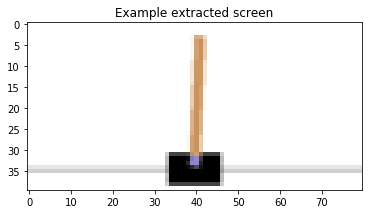

Action_space=Discrete(2)
Obs_space=Box(4,)
Threshold=475.0 

DIR=./preTrained/dqn NAME=dqn_CartPole-v1_42
No models to load

Training started ... 
Ep:    0  Rew:   17.00  Avg Rew:   17.00  LR:0.00100000  Bf: 0  EPS:0.5000  Loss: 0.468
Ep:   10  Rew:   18.00  Avg Rew:   18.27  LR:0.00099900  Bf: 0  EPS:0.4902  Loss: 1.144
Ep:   20  Rew:   12.00  Avg Rew:   18.71  LR:0.00099800  Bf: 0  EPS:0.4808  Loss: 4.147
Ep:   30  Rew:   12.00  Avg Rew:   22.77  LR:0.00099701  Bf: 0  EPS:0.4717  Loss: 12.086
Ep:   40  Rew:  295.00  Avg Rew:   44.59  LR:0.00099602  Bf: 0  EPS:0.4630  Loss: 13.948
Ep:   50  Rew:  209.00  Avg Rew:   54.63  LR:0.00099502  Bf: 0  EPS:0.4545  Loss: 17.724
Ep:   60  Rew:   65.00  Avg Rew:   56.10  LR:0.00099404  Bf: 0  EPS:0.4464  Loss: 30.198
Ep:   70  Rew:   23.00  Avg Rew:   58.77  LR:0.00099305  Bf: 0  EPS:0.4386  Loss: 31.822
Ep:   80  Rew:   75.00  Avg Rew:   65.31  LR:0.00099206  Bf: 0  EPS:0.4310  Loss: 40.430
Ep:   90  Rew:   83.00  Avg Rew:   63.79  LR:0.00099108

OSError: [Errno 12] Cannot allocate memory

In [5]:
agent = DQN_Conv_Trainer(env_name, config, random_seed=random_seed, lr_base=lr_base, lr_decay=lr_decay, 
                   epsilon_base=epsilon_base, epsilon_decay=epsilon_decay, gamma=gamma, batch_size=batch_size,
                   max_episodes=max_episodes, max_timesteps=max_timesteps, 
                   max_buffer_length=max_buffer_length, log_interval=log_interval)
agent.train()

In [ ]:
agent.test()